# Methods of Gesture Recognition

## Classifiers

- Support Vector Machine
- Random Forrest
- k-NN
- XGBoost
- Hidden Markov Model

## Deep Learning

- 1D Convolutional Neural Network
- Long Short-Term Memory
- Bidirectional LSTM
- Gated Recurrent Unit
- 3D Convolutional Neural Network
- Temporal Convolutional Network
- Transformer and Attention Mechanism
- Autoencoders for Dimensionailty Reduction
- Hybrid CNN-RNN Architecture

## Time Series Handling

- Dynamic Time Warping
- Sliding Window with Feature Extraction
- Shapelet-Based Classification
- Sequence-to-Secquence
- Connectionist Temporal Classification
- Early Time Series Classification

## Evaluation Techniques

- Train on some users, test on others
- Add all users to train/test

In [4]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import sqlite3
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn-v0_8-darkgrid')
%matplotlib inline
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

print("Libraries loaded successfully!")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Libraries loaded successfully!


In [2]:
db_path = "./labeled.sqlite"

In [3]:
query = """
WITH start_end_indices AS (
    SELECT 
        s.session_task_id,
        s.sensor_data_index AS start_index,
        (
            SELECT e.sensor_data_index
            FROM preciseMarker e
            WHERE e.marker_type = 'end'
            AND e.sensor_data_index > s.sensor_data_index
            AND e.session_task_id = s.session_task_id
            ORDER BY e.sensor_data_index ASC
            LIMIT 1
        ) AS next_end_index
    FROM preciseMarker s
    WHERE s.marker_type = 'start'
    group by s.session_task_id, s.sensor_data_index
)
select 
    (select sdd.timestamp from sensorData sdd where sdd.session_task_id = sd.session_task_id and sdd.session_task_row_index = sei.start_index) as group_id,
    sd.id,
    sd.session_task_id,
    rt.title as gesture,
    rtParent.title as parent_gesture,
    sd.timestamp,
    sd.button_pressed,
    sd.motor_angle,
    sd.touch_1_position,
    sd.touch_1_pressure,
    sd.touch_1_channel,
    sd.touch_2_position,
    sd.touch_2_pressure,
    sd.touch_2_channel,
    sd.touch_3_position,
    sd.touch_3_pressure,
    sd.touch_3_channel,
    sd.touch_4_position,
    sd.touch_4_pressure,
    sd.touch_4_channel,
    sd.touch_5_position,
    sd.touch_5_pressure,
    sd.touch_5_channel
from sensorData sd
    join start_end_indices sei
        on sd.session_task_id = sei.session_task_id
        and sd.session_task_row_index >= sei.start_index
        and sd.session_task_row_index <= sei.next_end_index
    LEFT JOIN sessionTask st
        ON sd.session_task_id = st.id
    LEFT JOIN recordingTask rt
        ON st.recording_task_id = rt.id
    LEFT JOIN recordingTask rtParent
        ON rt.parent_id = rtParent.id;
"""

with sqlite3.connect(db_path) as conn:
    # Use pandas to execute the query and load results into a DataFrame
    df = pd.read_sql_query(query, conn)

df.head()

,group_id,id,session_task_id,gesture,parent_gesture,timestamp,button_pressed,motor_angle,touch_1_position,touch_1_pressure,...,touch_2_channel,touch_3_position,touch_3_pressure,touch_3_channel,touch_4_position,touch_4_pressure,touch_4_channel,touch_5_position,touch_5_pressure,touch_5_channel
0,2025-10-03 15:35:07,81cc6bb7-376e-4e74-8d59-9a5d03e002ca,c9168e6c-5bfc-43fc-a6dc-8621e72c32de,Pinch Swipe (Links),Pinch Swipe,2025-10-03 15:35:07,0,-2.075093,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2025-10-03 15:35:07,2bb09a7d-82ee-42e5-a958-37790f280b24,c9168e6c-5bfc-43fc-a6dc-8621e72c32de,Pinch Swipe (Links),Pinch Swipe,2025-10-03 15:35:07,0,-2.073942,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2025-10-03 15:35:07,f6d93483-274e-4196-9a43-d5f08e7637c3,c9168e6c-5bfc-43fc-a6dc-8621e72c32de,Pinch Swipe (Links),Pinch Swipe,2025-10-03 15:35:07,0,-2.075093,6.230826,49.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2025-10-03 15:35:07,756acd1c-2ed2-472b-849e-d4b55b563dd0,c9168e6c-5bfc-43fc-a6dc-8621e72c32de,Pinch Swipe (Links),Pinch Swipe,2025-10-03 15:35:07,0,-2.073175,6.230826,62.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2025-10-03 15:35:07,daf58b37-e580-4fd7-a173-625af0baeed7,c9168e6c-5bfc-43fc-a6dc-8621e72c32de,Pinch Swipe (Links),Pinch Swipe,2025-10-03 15:35:07,0,-2.073559,6.192106,119.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
print(f"Data loaded: {df.shape[0]} rows, {df.shape[1]} columns")

Data loaded: 40646 rows, 23 columns


In [9]:
df['timestamp'] = pd.to_datetime(df['timestamp'])
df['time_diff'] = df.groupby(['session_task_id', 'timestamp']).cumcount()
df['recordings_per_second'] = df.groupby(['session_task_id', 'timestamp'])['id'].transform('count')
df['estimated_timestamp'] = df['timestamp'] + pd.to_timedelta(df['time_diff'] / df['recordings_per_second'], unit='s')
df = df.drop(columns=['time_diff', 'recordings_per_second'])

df["timestamp_ms"] = (df["estimated_timestamp"].astype(np.int64) // 10**6).astype(np.int64)

In [10]:
# Display basic info about the dataset
print("=" * 80)
print("DATASET INFORMATION")
print("=" * 80)
df.info()

print("\n" + "=" * 80)
print("BASIC STATISTICS")
print("=" * 80)
df.describe()


DATASET INFORMATION
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40646 entries, 0 to 40645
Data columns (total 25 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   group_id             40646 non-null  object        
 1   id                   40646 non-null  object        
 2   session_task_id      40646 non-null  object        
 3   gesture              40646 non-null  object        
 4   parent_gesture       40646 non-null  object        
 5   timestamp            40646 non-null  datetime64[ns]
 6   button_pressed       40646 non-null  int64         
 7   motor_angle          40646 non-null  float64       
 8   touch_1_position     36281 non-null  float64       
 9   touch_1_pressure     36281 non-null  float64       
 10  touch_1_channel      36281 non-null  float64       
 11  touch_2_position     31346 non-null  float64       
 12  touch_2_pressure     31346 non-null  float64       
 13  touch_2_cha

,timestamp,button_pressed,motor_angle,touch_1_position,touch_1_pressure,touch_1_channel,touch_2_position,touch_2_pressure,touch_2_channel,touch_3_position,touch_3_pressure,touch_3_channel,touch_4_position,touch_4_pressure,touch_4_channel,touch_5_position,touch_5_pressure,touch_5_channel,estimated_timestamp,timestamp_ms
count,40646,40646.000000,40646.000000,36281.000000,36281.000000,36281.000000,31346.000000,31346.000000,31346.000000,14160.000000,14160.000000,14160.000000,3842.000000,3842.000000,3842.000000,1042.000000,1042.000000,1042.000000,40646,4.064600e+04
mean,2025-10-05 10:16:48.376248576,0.022192,114.540768,2.015316,1101.560100,3.688708,3.519015,1101.523512,3.701876,3.957052,1241.357486,3.906780,4.639881,1152.151484,3.726445,4.900702,870.159309,3.408829,2025-10-05 10:16:48.862052864,1.759659e+12
min,2025-10-03 15:35:07,0.000000,-3.979530,0.012961,41.000000,1.000000,0.000377,41.000000,1.000000,0.000102,41.000000,1.000000,0.000082,41.000000,1.000000,0.001951,56.000000,1.000000,2025-10-03 15:35:07,1.759506e+12
25%,2025-10-03 15:57:23,0.000000,82.461823,0.873977,609.000000,3.000000,2.780852,614.000000,3.000000,3.513073,898.000000,3.000000,4.240364,693.250000,3.000000,5.083119,510.250000,3.000000,2025-10-03 15:57:23.468750080,1.759507e+12
50%,2025-10-03 16:37:38,0.000000,114.877136,1.821349,1050.000000,4.000000,3.508112,979.000000,4.000000,4.210815,1183.000000,4.000000,4.968648,1088.500000,4.000000,5.744658,805.000000,3.000000,2025-10-03 16:37:38.439188992,1.759509e+12
75%,2025-10-07 13:35:34,0.000000,174.924057,2.854886,1457.000000,4.000000,4.589278,1400.000000,4.000000,5.374194,1525.000000,4.000000,5.825548,1520.000000,4.000000,6.001359,1110.750000,4.000000,2025-10-07 13:35:34.592857088,1.759844e+12
max,2025-10-07 14:05:04,1.000000,193.055328,6.280106,3711.000000,10.000000,6.282874,4864.000000,11.000000,6.282576,3417.000000,7.000000,6.282197,2942.000000,8.000000,6.282785,2464.000000,7.000000,2025-10-07 14:05:04.966666667,1.759846e+12
std,NaN,0.147308,62.281985,1.315330,651.911988,1.160949,1.604860,724.467656,1.271013,1.852943,574.324406,0.962425,1.622429,612.345330,1.025767,1.974977,496.538041,0.994625,NaN,1.674564e+08


In [11]:
# Check data types and identify columns
print("\n" + "=" * 80)
print("COLUMN CATEGORIZATION")
print("=" * 80)

# Identify different types of columns
timestamp_cols = ['group_id', 'timestamp']
label_cols = ['gesture', 'parent_gesture']
button_cols = ['button_pressed']
motor_cols = ['motor_angle']
touch_position_cols = [f'touch_{i}_position' for i in range(1, 6)]
touch_pressure_cols = [f'touch_{i}_pressure' for i in range(1, 6)]
touch_channel_cols = [f'touch_{i}_channel' for i in range(1, 6)]

print(f"Timestamp columns: {timestamp_cols}")
print(f"Label columns: {label_cols}")
print(f"Button columns: {button_cols}")
print(f"Motor columns: {motor_cols}")
print(f"Touch position columns: {touch_position_cols}")
print(f"Touch pressure columns: {touch_pressure_cols}")
print(f"Touch channel columns: {touch_channel_cols}")



COLUMN CATEGORIZATION
Timestamp columns: ['group_id', 'timestamp']
Label columns: ['gesture', 'parent_gesture']
Button columns: ['button_pressed']
Motor columns: ['motor_angle']
Touch position columns: ['touch_1_position', 'touch_2_position', 'touch_3_position', 'touch_4_position', 'touch_5_position']
Touch pressure columns: ['touch_1_pressure', 'touch_2_pressure', 'touch_3_pressure', 'touch_4_pressure', 'touch_5_pressure']
Touch channel columns: ['touch_1_channel', 'touch_2_channel', 'touch_3_channel', 'touch_4_channel', 'touch_5_channel']



MISSING VALUE ANALYSIS

Columns with missing values:
                  Missing_Count  Missing_Percentage
touch_5_pressure          39604           97.436402
touch_5_channel           39604           97.436402
touch_5_position          39604           97.436402
touch_4_position          36804           90.547655
touch_4_pressure          36804           90.547655
touch_4_channel           36804           90.547655
touch_3_pressure          26486           65.162624
touch_3_channel           26486           65.162624
touch_3_position          26486           65.162624
touch_2_channel            9300           22.880480
touch_2_pressure           9300           22.880480
touch_2_position           9300           22.880480
touch_1_position           4365           10.739064
touch_1_channel            4365           10.739064
touch_1_pressure           4365           10.739064


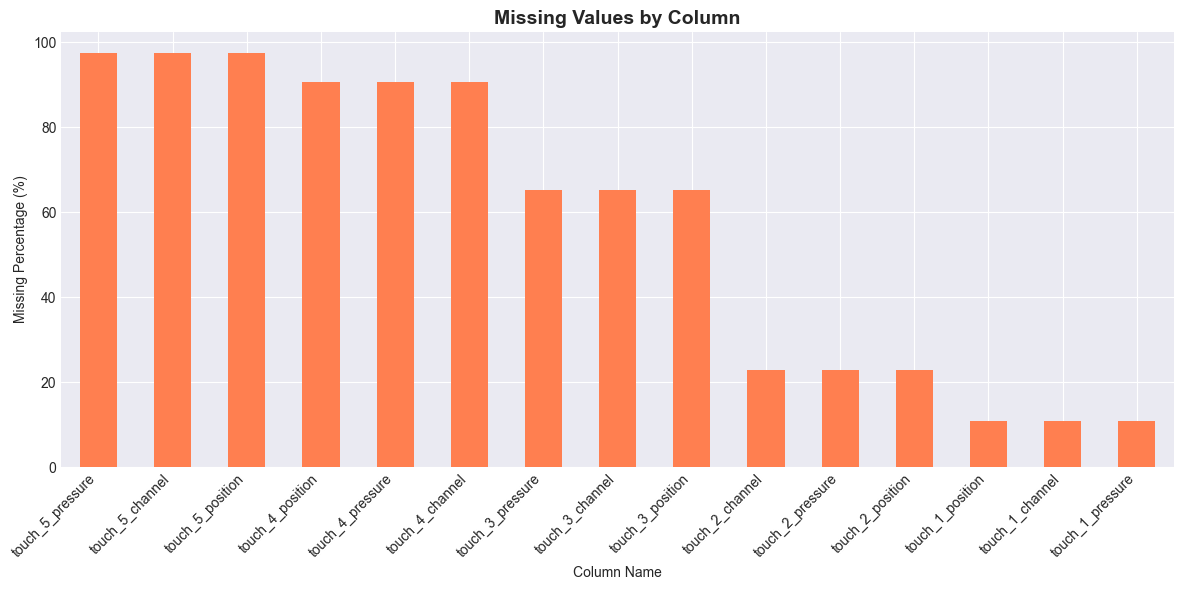

In [12]:
print("\n" + "=" * 80)
print("MISSING VALUE ANALYSIS")
print("=" * 80)

# Count missing values per column
missing_counts = df.isnull().sum()
missing_percentages = (missing_counts / len(df)) * 100

missing_df = pd.DataFrame({
    'Missing_Count': missing_counts,
    'Missing_Percentage': missing_percentages
}).sort_values('Missing_Count', ascending=False)

# Display only columns with missing values
missing_with_nulls = missing_df[missing_df['Missing_Count'] > 0]
if len(missing_with_nulls) > 0:
    print("\nColumns with missing values:")
    print(missing_with_nulls)
else:
    print("\n✓ No missing values detected!")

# Visualize missing data
if len(missing_with_nulls) > 0:
    fig, ax = plt.subplots(figsize=(12, 6))
    missing_with_nulls['Missing_Percentage'].plot(kind='bar', ax=ax, color='coral')
    ax.set_ylabel('Missing Percentage (%)')
    ax.set_title('Missing Values by Column', fontsize=14, fontweight='bold')
    ax.set_xlabel('Column Name')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()


In [13]:
print("\n" + "=" * 80)
print("GESTURE CLASS DISTRIBUTION")
print("=" * 80)

# Count unique gestures per group_id (gesture instance)
gesture_counts = df.groupby('group_id')['gesture'].first().value_counts()
print(f"\nTotal unique gesture classes: {df['gesture'].nunique()}")
print(f"Total gesture instances: {df['group_id'].nunique()}")
print(f"\nGesture instance counts:")
print(gesture_counts)

# Check for class imbalance
print(f"\n{'=' * 50}")
print("CLASS BALANCE ANALYSIS")
print(f"{'=' * 50}")

total_instances = len(gesture_counts)
gesture_percentages = (gesture_counts / total_instances) * 100

balance_df = pd.DataFrame({
    'Count': gesture_counts,
    'Percentage': gesture_percentages
})
print(balance_df)

# Calculate imbalance ratio
max_class = gesture_counts.max()
min_class = gesture_counts.min()
imbalance_ratio = max_class / min_class
print(f"\nImbalance Ratio (max/min): {imbalance_ratio:.2f}")

if imbalance_ratio > 3:
    print("⚠️ WARNING: Significant class imbalance detected!")
    print("   Consider using: class weights, resampling, or stratified splits")
else:
    print("✓ Classes are relatively balanced")



GESTURE CLASS DISTRIBUTION

Total unique gesture classes: 26
Total gesture instances: 641

Gesture instance counts:
gesture
Two-Finger Tap (3 Finger)                    28
Tap and Hold (3 Finger)                      27
Lay On (3 Fingers)                           26
Two-Finger Double Tap (4 Finger)             26
Single Tap (3 Finger, Luft)                  26
Two-Finger Opposite Tap (All Air)            26
Double Tap (4 Finger)                        25
Knob Turn (3 Fingers)                        25
Single Swipe (3 Finger)                      25
Tap and Hold (2 Finger)                      25
Spread Swipe (Rechts)                        25
Lay On (2 Fingers)                           25
Two-Finger Opposite Double Tap (4 Finger)    24
Single Tap (4 Finger)                        24
Double Tap (3 Finger, Luft)                  24
Pinch Swipe (Rechts)                         24
Pinch Swipe (Links)                          24
Two-Finger Opposite Tap (4 Finger)           24
Two-Finger 

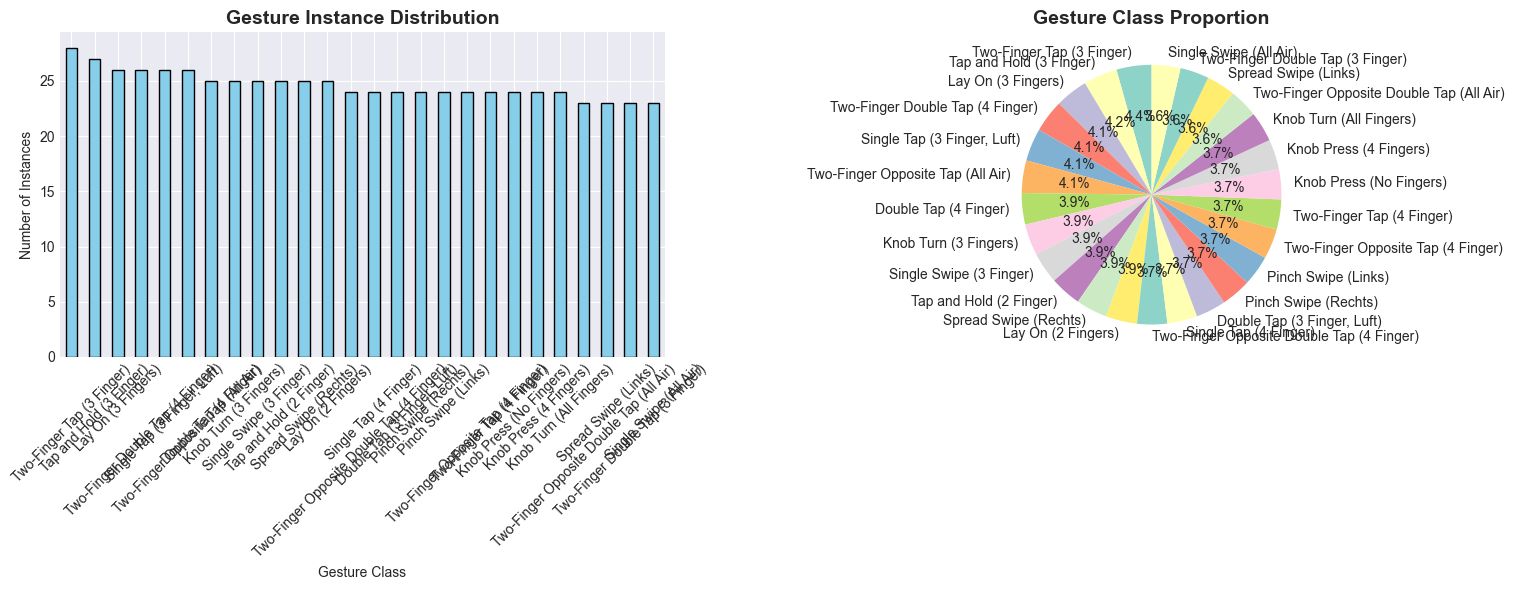

In [14]:
# Visualize gesture distribution
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Bar plot
gesture_counts.plot(kind='bar', ax=ax1, color='skyblue', edgecolor='black')
ax1.set_title('Gesture Instance Distribution', fontsize=14, fontweight='bold')
ax1.set_xlabel('Gesture Class')
ax1.set_ylabel('Number of Instances')
ax1.tick_params(axis='x', rotation=45)

# Pie chart
ax2.pie(gesture_counts, labels=gesture_counts.index, autopct='%1.1f%%', 
        startangle=90, colors=plt.cm.Set3.colors)
ax2.set_title('Gesture Class Proportion', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()



PARENT GESTURE DISTRIBUTION
parent_gesture
No Gesture                        148
Tap and Hold                       52
Two-Finger Tap                     52
Two-Finger Opposite Tap            50
Single Tap                         50
Two-Finger Double Tap              49
Double Tap                         49
Pinch Swipe                        48
Spread Swipe                       48
Single Swipe                       48
Two-Finger Opposite Double Tap     47
Name: count, dtype: int64


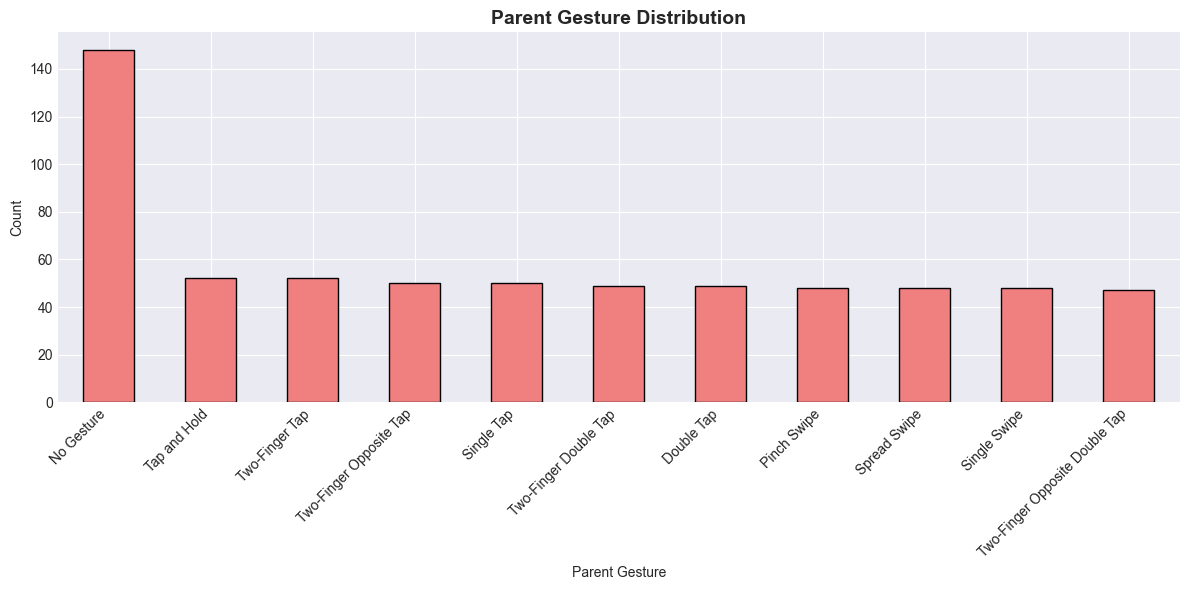

In [15]:
# Analyze parent gestures if applicable
if 'parent_gesture' in df.columns and df['parent_gesture'].notna().any():
    print("\n" + "=" * 80)
    print("PARENT GESTURE DISTRIBUTION")
    print("=" * 80)
    
    parent_counts = df.groupby('group_id')['parent_gesture'].first().value_counts()
    print(parent_counts)
    
    # Visualize parent gesture hierarchy
    fig, ax = plt.subplots(figsize=(12, 6))
    parent_counts.plot(kind='bar', ax=ax, color='lightcoral', edgecolor='black')
    ax.set_title('Parent Gesture Distribution', fontsize=14, fontweight='bold')
    ax.set_xlabel('Parent Gesture')
    ax.set_ylabel('Count')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()


In [16]:
print("\n" + "=" * 80)
print("TEMPORAL ANALYSIS: GESTURE DURATION")
print("=" * 80)

# Convert timestamps to datetime if they're not already
df['timestamp'] = pd.to_datetime(df['timestamp'])
df['group_id'] = pd.to_datetime(df['group_id'])

# Calculate duration and sample count for each gesture instance
gesture_stats = df.groupby('group_id').agg({
    'timestamp': ['min', 'max', 'count'],
    'gesture': 'first'
})

# Flatten multi-level columns
gesture_stats.columns = ['start_time', 'end_time', 'n_samples', 'gesture']
gesture_stats['duration_ms'] = (gesture_stats['end_time'] - gesture_stats['start_time']).dt.total_seconds() * 1000

# Overall statistics
print(f"\nGesture Duration Statistics (milliseconds):")
print(gesture_stats['duration_ms'].describe())

print(f"\nSamples per Gesture Statistics:")
print(gesture_stats['n_samples'].describe())

# Calculate sampling rate
gesture_stats['sampling_rate_hz'] = gesture_stats['n_samples'] / (gesture_stats['duration_ms'] / 1000)
gesture_stats['sampling_rate_hz'] = gesture_stats['sampling_rate_hz'].replace([np.inf, -np.inf], np.nan)

print(f"\nEstimated Sampling Rate (Hz):")
print(gesture_stats['sampling_rate_hz'].describe())

avg_sampling_rate = gesture_stats['sampling_rate_hz'].median()
print(f"\n✓ Median sampling rate: {avg_sampling_rate:.1f} Hz")
print(f"  → One sample every ~{1000/avg_sampling_rate:.1f} ms")



TEMPORAL ANALYSIS: GESTURE DURATION

Gesture Duration Statistics (milliseconds):
count     641.00000
mean      804.99220
std       853.87355
min         0.00000
25%         0.00000
50%      1000.00000
75%      1000.00000
max      6000.00000
Name: duration_ms, dtype: float64

Samples per Gesture Statistics:
count    641.000000
mean      63.410296
std       63.167128
min        9.000000
25%       21.000000
50%       34.000000
75%       94.000000
max      862.000000
Name: n_samples, dtype: float64

Estimated Sampling Rate (Hz):
count    373.000000
mean      65.038204
std       29.950741
min        9.000000
25%       43.000000
50%       67.000000
75%       82.333333
max      143.666667
Name: sampling_rate_hz, dtype: float64

✓ Median sampling rate: 67.0 Hz
  → One sample every ~14.9 ms


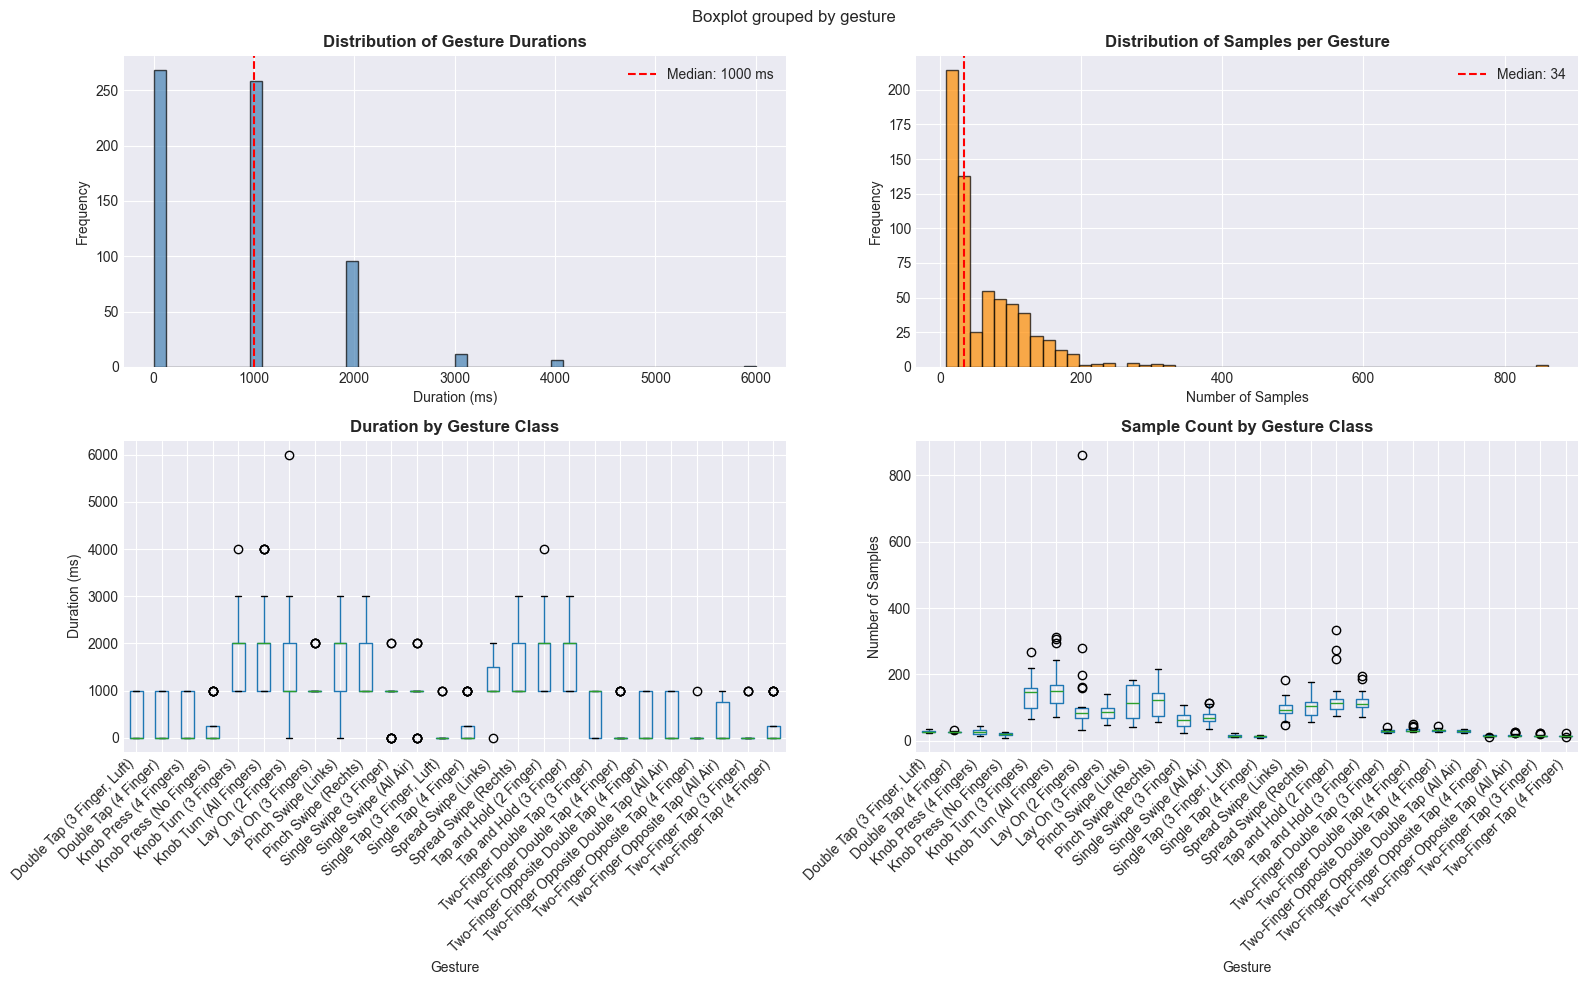

In [17]:
# Visualize duration distributions
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# Duration histogram
axes[0, 0].hist(gesture_stats['duration_ms'], bins=50, color='steelblue', edgecolor='black', alpha=0.7)
axes[0, 0].set_xlabel('Duration (ms)')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].set_title('Distribution of Gesture Durations', fontweight='bold')
axes[0, 0].axvline(gesture_stats['duration_ms'].median(), color='red', 
                    linestyle='--', label=f'Median: {gesture_stats["duration_ms"].median():.0f} ms')
axes[0, 0].legend()

# Samples per gesture histogram
axes[0, 1].hist(gesture_stats['n_samples'], bins=50, color='darkorange', edgecolor='black', alpha=0.7)
axes[0, 1].set_xlabel('Number of Samples')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].set_title('Distribution of Samples per Gesture', fontweight='bold')
axes[0, 1].axvline(gesture_stats['n_samples'].median(), color='red', 
                    linestyle='--', label=f'Median: {gesture_stats["n_samples"].median():.0f}')
axes[0, 1].legend()

# Duration by gesture class (boxplot)
gesture_stats.boxplot(column='duration_ms', by='gesture', ax=axes[1, 0], rot=45)
axes[1, 0].set_title('Duration by Gesture Class', fontweight='bold')
axes[1, 0].set_xlabel('Gesture')
axes[1, 0].set_ylabel('Duration (ms)')
plt.sca(axes[1, 0])
plt.xticks(rotation=45, ha='right')

# Samples by gesture class (boxplot)
gesture_stats.boxplot(column='n_samples', by='gesture', ax=axes[1, 1], rot=45)
axes[1, 1].set_title('Sample Count by Gesture Class', fontweight='bold')
axes[1, 1].set_xlabel('Gesture')
axes[1, 1].set_ylabel('Number of Samples')
plt.sca(axes[1, 1])
plt.xticks(rotation=45, ha='right')

plt.tight_layout()
plt.show()


In [18]:
print("\n" + "=" * 80)
print("SENSOR CHANNEL ANALYSIS")
print("=" * 80)

# Analyze button presses
print("\nButton Press Distribution:")
button_dist = df['button_pressed'].value_counts()
print(button_dist)
print(f"Button press rate: {(df['button_pressed'] == True).sum() / len(df) * 100:.2f}%")

# Analyze motor angle
print("\nMotor Angle Statistics:")
print(df['motor_angle'].describe())

# Analyze touch sensors
print("\n" + "=" * 50)
print("TOUCH SENSOR ANALYSIS")
print("=" * 50)

for i in range(1, 6):
    position_col = f'touch_{i}_position'
    pressure_col = f'touch_{i}_pressure'
    
    # Check how often this touch sensor is active (pressure > 0)
    active_touches = df[pressure_col] > 0
    active_percentage = (active_touches.sum() / len(df)) * 100
    
    print(f"\nTouch Sensor {i}:")
    print(f"  Active: {active_percentage:.2f}% of samples")
    print(f"  Position range: [{df[position_col].min():.2f}, {df[position_col].max():.2f}]")
    print(f"  Pressure range: [{df[pressure_col].min():.2f}, {df[pressure_col].max():.2f}]")



SENSOR CHANNEL ANALYSIS

Button Press Distribution:
button_pressed
0    39744
1      902
Name: count, dtype: int64
Button press rate: 2.22%

Motor Angle Statistics:
count    40646.000000
mean       114.540768
std         62.281985
min         -3.979530
25%         82.461823
50%        114.877136
75%        174.924057
max        193.055328
Name: motor_angle, dtype: float64

TOUCH SENSOR ANALYSIS

Touch Sensor 1:
  Active: 89.26% of samples
  Position range: [0.01, 6.28]
  Pressure range: [41.00, 3711.00]

Touch Sensor 2:
  Active: 77.12% of samples
  Position range: [0.00, 6.28]
  Pressure range: [41.00, 4864.00]

Touch Sensor 3:
  Active: 34.84% of samples
  Position range: [0.00, 6.28]
  Pressure range: [41.00, 3417.00]

Touch Sensor 4:
  Active: 9.45% of samples
  Position range: [0.00, 6.28]
  Pressure range: [41.00, 2942.00]

Touch Sensor 5:
  Active: 2.56% of samples
  Position range: [0.00, 6.28]
  Pressure range: [56.00, 2464.00]


IndexError: index 3 is out of bounds for axis 0 with size 3

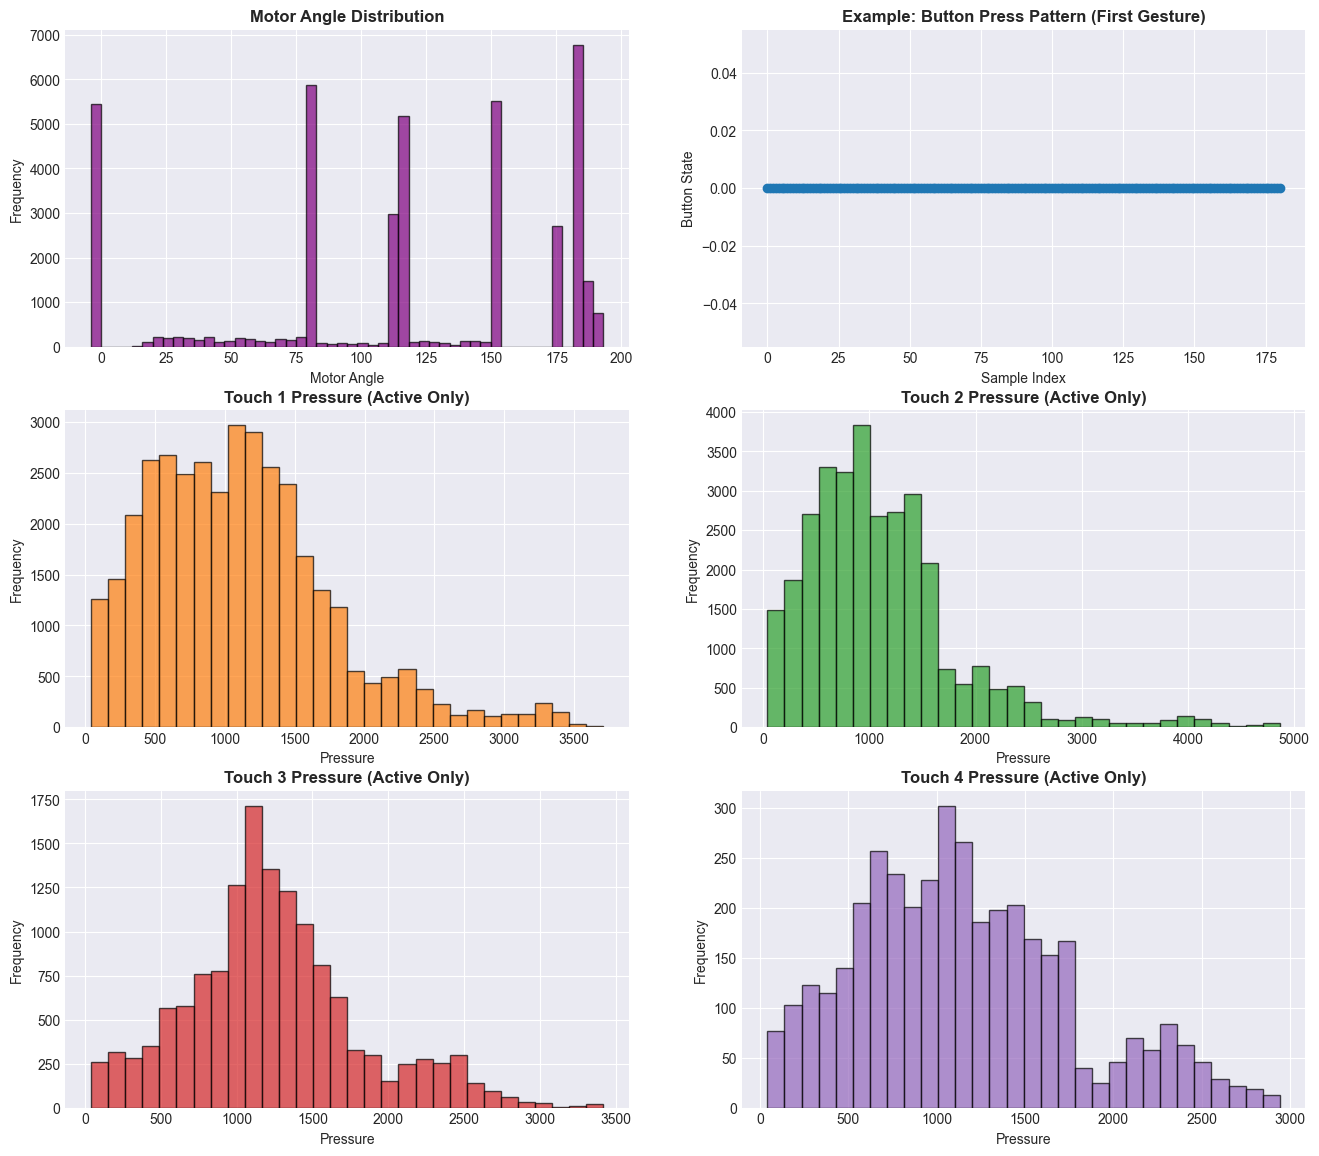

In [19]:
# Visualize sensor distributions
fig, axes = plt.subplots(3, 2, figsize=(16, 14))

# Motor angle distribution
axes[0, 0].hist(df['motor_angle'].dropna(), bins=50, color='purple', edgecolor='black', alpha=0.7)
axes[0, 0].set_xlabel('Motor Angle')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].set_title('Motor Angle Distribution', fontweight='bold')

# Button press over time (sample)
sample_gesture = df[df['group_id'] == df['group_id'].unique()[0]]
axes[0, 1].plot(sample_gesture.index, sample_gesture['button_pressed'], marker='o', linestyle='-')
axes[0, 1].set_xlabel('Sample Index')
axes[0, 1].set_ylabel('Button State')
axes[0, 1].set_title('Example: Button Press Pattern (First Gesture)', fontweight='bold')

# Touch pressure distributions
for i in range(1, 6):
    row = (i + 1) // 2
    col = (i + 1) % 2
    
    pressure_col = f'touch_{i}_pressure'
    # Filter out zero pressures for better visualization
    active_pressures = df[df[pressure_col] > 0][pressure_col]
    
    if len(active_pressures) > 0:
        axes[row, col].hist(active_pressures, bins=30, color=f'C{i}', edgecolor='black', alpha=0.7)
        axes[row, col].set_xlabel('Pressure')
        axes[row, col].set_ylabel('Frequency')
        axes[row, col].set_title(f'Touch {i} Pressure (Active Only)', fontweight='bold')
    else:
        axes[row, col].text(0.5, 0.5, f'Touch {i}\nNo Active Data', 
                           ha='center', va='center', fontsize=14)
        axes[row, col].set_xticks([])
        axes[row, col].set_yticks([])

plt.tight_layout()
plt.show()



SIMULTANEOUS TOUCH ANALYSIS

Active Touch Distribution:
active_touch_count
0     4365
1     4935
2    17186
3    10318
4     2800
5     1042
Name: count, dtype: int64


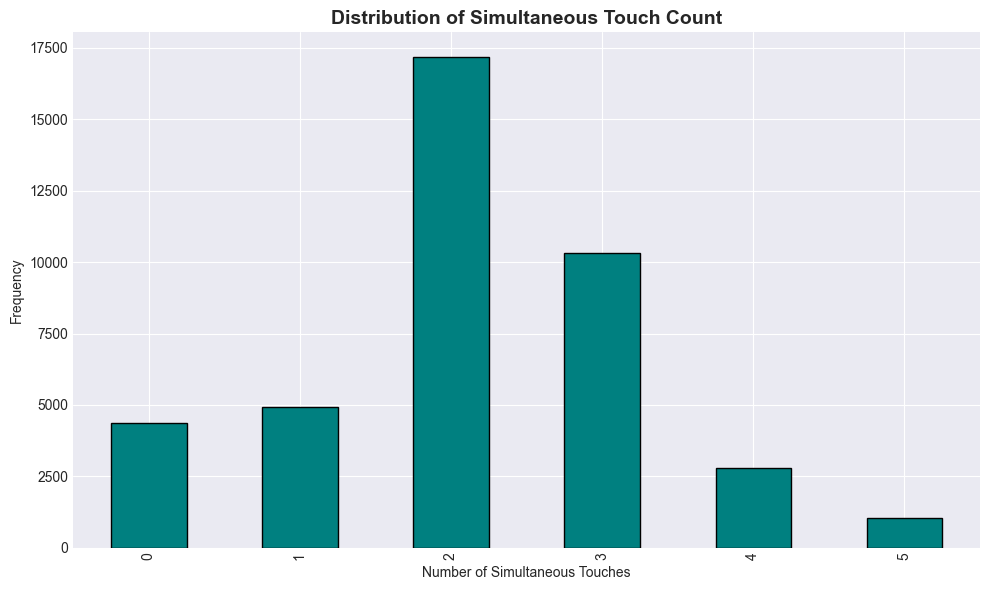

In [20]:
print("\n" + "=" * 80)
print("SIMULTANEOUS TOUCH ANALYSIS")
print("=" * 80)

# Count active touches per sample
df['active_touch_count'] = sum([(df[f'touch_{i}_pressure'] > 0).astype(int) for i in range(1, 6)])

print("\nActive Touch Distribution:")
touch_dist = df['active_touch_count'].value_counts().sort_index()
print(touch_dist)

# Visualize
fig, ax = plt.subplots(figsize=(10, 6))
touch_dist.plot(kind='bar', ax=ax, color='teal', edgecolor='black')
ax.set_xlabel('Number of Simultaneous Touches')
ax.set_ylabel('Frequency')
ax.set_title('Distribution of Simultaneous Touch Count', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()


In [23]:
print("\n" + "=" * 80)
print("SUMMARY AND RECOMMENDATIONS FOR PREPROCESSING")
print("=" * 80)

median_duration = gesture_stats['duration_ms'].median()
median_samples = gesture_stats['n_samples'].median()

print(f"\n📊 KEY FINDINGS:")
print(f"  • Total gesture instances: {df['group_id'].nunique()}")
print(f"  • Total gesture classes: {df['gesture'].nunique()}")
print(f"  • Median gesture duration: {median_duration:.0f} ms")
print(f"  • Median samples per gesture: {median_samples:.0f}")
print(f"  • Estimated sampling rate: {avg_sampling_rate:.1f} Hz")
print(f"  • Class imbalance ratio: {imbalance_ratio:.2f}x")

print(f"\n💡 RECOMMENDED NEXT STEPS:")

# Window size recommendation
recommended_window_ms = median_duration * 0.5  # 50% of median gesture
recommended_window_samples = int(recommended_window_ms / 1000 * avg_sampling_rate)
print(f"\n1. SLIDING WINDOW CONFIGURATION:")
print(f"   • Suggested window size: {recommended_window_samples} samples (~{recommended_window_ms:.0f} ms)")
print(f"   • Suggested overlap: {recommended_window_samples // 2} samples (50% overlap)")
print(f"   • Rationale: Captures ~50% of median gesture duration")

print(f"\n2. DATA CLEANING:")
if missing_with_nulls.shape[0] > 0:
    print(f"   • Handle missing values in: {', '.join(missing_with_nulls.index.tolist())}")
print(f"   • Consider filtering touch sensors with <1% activity")

print(f"\n3. CLASS IMBALANCE HANDLING:")
if imbalance_ratio > 3:
    print(f"   • Use stratified train/test splits")
    print(f"   • Consider class weights in model training")
    print(f"   • Evaluate using F1-score, not just accuracy")
else:
    print(f"   • Class distribution is acceptable")
    print(f"   • Standard train/test split is fine")

print(f"\n4. FEATURE ENGINEERING:")
print(f"   • Derive velocity/acceleration from motor_angle")
print(f"   • Compute touch trajectory features (distance, curvature)")
print(f"   • Extract statistical features (mean, std, min, max) per window")
print(f"   • Consider touch transition events (on/off)")

print("\n" + "=" * 80)



SUMMARY AND RECOMMENDATIONS FOR PREPROCESSING

📊 KEY FINDINGS:
  • Total gesture instances: 641
  • Total gesture classes: 26
  • Median gesture duration: 1000 ms
  • Median samples per gesture: 34
  • Estimated sampling rate: 67.0 Hz
  • Class imbalance ratio: 1.22x

💡 RECOMMENDED NEXT STEPS:

1. SLIDING WINDOW CONFIGURATION:
   • Suggested window size: 33 samples (~500 ms)
   • Suggested overlap: 16 samples (50% overlap)
   • Rationale: Captures ~50% of median gesture duration

2. DATA CLEANING:
   • Handle missing values in: touch_5_pressure, touch_5_channel, touch_5_position, touch_4_position, touch_4_pressure, touch_4_channel, touch_3_pressure, touch_3_channel, touch_3_position, touch_2_channel, touch_2_pressure, touch_2_position, touch_1_position, touch_1_channel, touch_1_pressure
   • Consider filtering touch sensors with <1% activity

3. CLASS IMBALANCE HANDLING:
   • Class distribution is acceptable
   • Standard train/test split is fine

4. FEATURE ENGINEERING:
   • Derive v

In [24]:
print("=" * 80)
print("SLIDING WINDOW CONFIGURATION")
print("=" * 80)

# Based on your EDA findings, set these parameters
# (These should come from your Section 1 analysis)
SAMPLING_RATE_HZ = 50  # Replace with your actual sampling rate from EDA
MEDIAN_GESTURE_DURATION_MS = 800  # Replace with your median duration from EDA

# Window parameters
WINDOW_SIZE_MS = 200  # Common for real-time gesture recognition (adjust based on your data)
WINDOW_OVERLAP_PERCENT = 50  # 50% overlap is standard

# Calculate window parameters in samples
WINDOW_SIZE_SAMPLES = int((WINDOW_SIZE_MS / 1000) * SAMPLING_RATE_HZ)
STEP_SIZE_SAMPLES = int(WINDOW_SIZE_SAMPLES * (1 - WINDOW_OVERLAP_PERCENT / 100))

print(f"\n📊 WINDOW PARAMETERS:")
print(f"  • Sampling rate: {SAMPLING_RATE_HZ} Hz")
print(f"  • Window size: {WINDOW_SIZE_MS} ms ({WINDOW_SIZE_SAMPLES} samples)")
print(f"  • Window overlap: {WINDOW_OVERLAP_PERCENT}%")
print(f"  • Step size: {STEP_SIZE_SAMPLES} samples")
print(f"  • Windows per second: {1000 / (STEP_SIZE_SAMPLES / SAMPLING_RATE_HZ * 1000):.1f}")

print(f"\n💡 RATIONALE:")
print(f"  • Window captures {WINDOW_SIZE_MS}ms of sensor data")
print(f"  • Overlap ensures smooth transitions between windows")
print(f"  • Real-time latency: ~{WINDOW_SIZE_MS}ms per prediction")


SLIDING WINDOW CONFIGURATION

📊 WINDOW PARAMETERS:
  • Sampling rate: 50 Hz
  • Window size: 200 ms (10 samples)
  • Window overlap: 50%
  • Step size: 5 samples
  • Windows per second: 10.0

💡 RATIONALE:
  • Window captures 200ms of sensor data
  • Overlap ensures smooth transitions between windows
  • Real-time latency: ~200ms per prediction


In [25]:
# Define all sensor channels (based on your SQL schema)
SENSOR_COLUMNS = [
    'button_pressed',
    'motor_angle',
    'touch_1_position', 'touch_1_pressure', 'touch_1_channel',
    'touch_2_position', 'touch_2_pressure', 'touch_2_channel',
    'touch_3_position', 'touch_3_pressure', 'touch_3_channel',
    'touch_4_position', 'touch_4_pressure', 'touch_4_channel',
    'touch_5_position', 'touch_5_pressure', 'touch_5_channel',
]

# Categorical vs continuous
CATEGORICAL_SENSORS = ['button_pressed', 'touch_1_channel', 'touch_2_channel', 
                       'touch_3_channel', 'touch_4_channel', 'touch_5_channel']
CONTINUOUS_SENSORS = [col for col in SENSOR_COLUMNS if col not in CATEGORICAL_SENSORS]

print(f"\n📡 SENSOR CONFIGURATION:")
print(f"  • Total sensor channels: {len(SENSOR_COLUMNS)}")
print(f"  • Continuous sensors: {len(CONTINUOUS_SENSORS)}")
print(f"  • Categorical sensors: {len(CATEGORICAL_SENSORS)}")



📡 SENSOR CONFIGURATION:
  • Total sensor channels: 17
  • Continuous sensors: 11
  • Categorical sensors: 6


In [26]:
print("\n" + "=" * 80)
print("DATA PREPROCESSING")
print("=" * 80)

# Create a copy to preserve original data
df_clean = df.copy()

# Convert timestamps to datetime if not already
df_clean['timestamp'] = pd.to_datetime(df_clean['timestamp'])
df_clean['group_id'] = pd.to_datetime(df_clean['group_id'])

# Sort by group_id and timestamp to ensure proper ordering
df_clean = df_clean.sort_values(['group_id', 'timestamp']).reset_index(drop=True)

# Handle missing values (if any were detected in EDA)
# Option 1: Forward fill within each gesture group
for col in SENSOR_COLUMNS:
    df_clean[col] = df_clean.groupby('group_id')[col].fillna(method='ffill')
    df_clean[col] = df_clean.groupby('group_id')[col].fillna(method='bfill')

# Option 2: Fill remaining NaNs with 0 (for pressure/position sensors)
df_clean[SENSOR_COLUMNS] = df_clean[SENSOR_COLUMNS].fillna(0)

# Convert button_pressed to integer (0/1)
df_clean['button_pressed'] = df_clean['button_pressed'].astype(int)

print(f"✓ Data cleaned and preprocessed")
print(f"  Rows: {len(df_clean)}")
print(f"  Gesture instances: {df_clean['group_id'].nunique()}")
print(f"  Gesture classes: {df_clean['gesture'].nunique()}")



DATA PREPROCESSING
✓ Data cleaned and preprocessed
  Rows: 40646
  Gesture instances: 641
  Gesture classes: 26


In [27]:
def create_sliding_windows(gesture_df, window_size, step_size):
    """
    Create sliding windows from a single gesture instance.
    
    Parameters:
    -----------
    gesture_df : DataFrame
        Data for a single gesture instance (all rows with same group_id)
    window_size : int
        Number of samples per window
    step_size : int
        Number of samples to slide the window
        
    Returns:
    --------
    windows : np.ndarray
        Array of shape (n_windows, window_size, n_features)
    window_labels : list
        Gesture label for each window
    window_metadata : list
        Metadata for each window (start_idx, end_idx, group_id)
    """
    gesture_df = gesture_df.sort_values('timestamp').reset_index(drop=True)
    
    # Extract sensor data
    sensor_data = gesture_df[SENSOR_COLUMNS].values
    gesture_label = gesture_df['gesture'].iloc[0]
    group_id = gesture_df['group_id'].iloc[0]
    
    n_samples = len(sensor_data)
    windows = []
    window_labels = []
    window_metadata = []
    
    # Slide the window across the gesture
    for start_idx in range(0, n_samples - window_size + 1, step_size):
        end_idx = start_idx + window_size
        
        # Extract window
        window = sensor_data[start_idx:end_idx]
        
        # Store window and label
        windows.append(window)
        window_labels.append(gesture_label)
        window_metadata.append({
            'group_id': group_id,
            'start_idx': start_idx,
            'end_idx': end_idx,
            'gesture': gesture_label
        })
    
    return np.array(windows), window_labels, window_metadata


# Test on a single gesture
test_group = df_clean['group_id'].iloc[0]
test_gesture = df_clean[df_clean['group_id'] == test_group]

test_windows, test_labels, test_meta = create_sliding_windows(
    test_gesture, 
    WINDOW_SIZE_SAMPLES, 
    STEP_SIZE_SAMPLES
)

print(f"\n🔍 TEST: Single Gesture Windowing")
print(f"  Gesture: {test_labels[0]}")
print(f"  Original samples: {len(test_gesture)}")
print(f"  Windows created: {len(test_windows)}")
print(f"  Window shape: {test_windows[0].shape}")
print(f"  (window_size={WINDOW_SIZE_SAMPLES}, n_features={len(SENSOR_COLUMNS)})")



🔍 TEST: Single Gesture Windowing
  Gesture: Pinch Swipe (Links)
  Original samples: 181
  Windows created: 35
  Window shape: (10, 17)
  (window_size=10, n_features=17)


In [28]:
print("\n" + "=" * 80)
print("CREATING SLIDING WINDOWS FOR ALL GESTURES")
print("=" * 80)

all_windows = []
all_labels = []
all_metadata = []

# Process each gesture instance
gesture_groups = df_clean.groupby('group_id')
total_gestures = len(gesture_groups)

for idx, (group_id, gesture_df) in enumerate(gesture_groups):
    if (idx + 1) % 50 == 0:
        print(f"  Processing gesture {idx + 1}/{total_gestures}...")
    
    windows, labels, metadata = create_sliding_windows(
        gesture_df,
        WINDOW_SIZE_SAMPLES,
        STEP_SIZE_SAMPLES
    )
    
    all_windows.extend(windows)
    all_labels.extend(labels)
    all_metadata.extend(metadata)

# Convert to numpy arrays
X_windows = np.array(all_windows)
y_labels = np.array(all_labels)

print(f"\n✓ Windowing complete!")
print(f"  Total windows created: {len(X_windows)}")
print(f"  Window shape: {X_windows.shape}")
print(f"  Unique gestures: {len(np.unique(y_labels))}")

# Display class distribution
print(f"\n📊 WINDOW LABEL DISTRIBUTION:")
unique, counts = np.unique(y_labels, return_counts=True)
for gesture, count in zip(unique, counts):
    percentage = (count / len(y_labels)) * 100
    print(f"  {gesture}: {count} windows ({percentage:.1f}%)")



CREATING SLIDING WINDOWS FOR ALL GESTURES
  Processing gesture 50/641...
  Processing gesture 100/641...
  Processing gesture 150/641...
  Processing gesture 200/641...
  Processing gesture 250/641...
  Processing gesture 300/641...
  Processing gesture 350/641...
  Processing gesture 400/641...
  Processing gesture 450/641...
  Processing gesture 500/641...
  Processing gesture 550/641...
  Processing gesture 600/641...

✓ Windowing complete!
  Total windows created: 7232
  Window shape: (7232, 10, 17)
  Unique gestures: 26

📊 WINDOW LABEL DISTRIBUTION:
  Double Tap (3 Finger, Luft): 105 windows (1.5%)
  Double Tap (4 Finger): 103 windows (1.4%)
  Knob Press (4 Fingers): 97 windows (1.3%)
  Knob Press (No Fingers): 62 windows (0.9%)
  Knob Turn (3 Fingers): 644 windows (8.9%)
  Knob Turn (All Fingers): 719 windows (9.9%)
  Lay On (2 Fingers): 605 windows (8.4%)
  Lay On (3 Fingers): 416 windows (5.8%)
  Pinch Swipe (Links): 534 windows (7.4%)
  Pinch Swipe (Rechts): 541 windows (7.5%

In [29]:
print("\n" + "=" * 80)
print("FEATURE EXTRACTION FROM WINDOWS")
print("=" * 80)

def extract_window_features(window):
    """
    Extract statistical features from a single window.
    
    Parameters:
    -----------
    window : np.ndarray
        Shape (window_size, n_features)
        
    Returns:
    --------
    features : np.ndarray
        1D array of extracted features
    """
    features = []
    
    # For each sensor channel
    for channel_idx in range(window.shape[1]):
        channel_data = window[:, channel_idx]
        
        # Time-domain statistics
        features.append(np.mean(channel_data))           # Mean
        features.append(np.std(channel_data))            # Standard deviation
        features.append(np.min(channel_data))            # Minimum
        features.append(np.max(channel_data))            # Maximum
        features.append(np.median(channel_data))         # Median
        
        # Additional features
        features.append(np.percentile(channel_data, 25)) # Q1
        features.append(np.percentile(channel_data, 75)) # Q3
        
        # Velocity (rate of change)
        if len(channel_data) > 1:
            velocity = np.diff(channel_data)
            features.append(np.mean(velocity))           # Mean velocity
            features.append(np.std(velocity))            # Velocity variance
        else:
            features.append(0)
            features.append(0)
        
        # Zero crossing rate (for continuous sensors)
        if channel_idx not in [0]:  # Skip button_pressed
            zero_crossings = np.sum(np.diff(np.sign(channel_data - np.mean(channel_data))) != 0)
            features.append(zero_crossings)
        else:
            features.append(0)
    
    return np.array(features)


# Extract features for all windows
print("Extracting features from windows...")
X_features = np.array([extract_window_features(window) for window in X_windows])

print(f"\n✓ Feature extraction complete!")
print(f"  Feature matrix shape: {X_features.shape}")
print(f"  Features per window: {X_features.shape[1]}")
print(f"  (10 features × {len(SENSOR_COLUMNS)} sensor channels)")



FEATURE EXTRACTION FROM WINDOWS
Extracting features from windows...

✓ Feature extraction complete!
  Feature matrix shape: (7232, 170)
  Features per window: 170
  (10 features × 17 sensor channels)


In [30]:
print("\n" + "=" * 80)
print("TRAIN/TEST SPLIT (PREVENTING DATA LEAKAGE)")
print("=" * 80)

from sklearn.model_selection import train_test_split

# Create metadata DataFrame to track which windows belong to which gestures
metadata_df = pd.DataFrame(all_metadata)

# Get unique gesture instances
unique_gesture_instances = metadata_df[['group_id', 'gesture']].drop_duplicates()

print(f"Total gesture instances: {len(unique_gesture_instances)}")
print(f"\nGesture instance distribution:")
print(unique_gesture_instances['gesture'].value_counts())

# CRITICAL: Split by group_id to prevent data leakage
# Windows from the same gesture instance must all be in train OR test, never split
train_groups, test_groups = train_test_split(
    unique_gesture_instances,
    test_size=0.2,
    random_state=42,
    stratify=unique_gesture_instances['gesture']  # Maintain class balance
)

print(f"\n✓ Split gesture instances:")
print(f"  Training gestures: {len(train_groups)}")
print(f"  Test gestures: {len(test_groups)}")

# Get indices of windows belonging to train/test groups
train_group_ids = set(train_groups['group_id'])
test_group_ids = set(test_groups['group_id'])

train_mask = metadata_df['group_id'].isin(train_group_ids)
test_mask = metadata_df['group_id'].isin(test_group_ids)

# Split windows
X_train_windows = X_windows[train_mask]
X_test_windows = X_windows[test_mask]
y_train = y_labels[train_mask]
y_test = y_labels[test_mask]

# Split features
X_train_features = X_features[train_mask]
X_test_features = X_features[test_mask]

print(f"\n✓ Windows split (no data leakage):")
print(f"  Training windows: {len(X_train_windows)} ({len(X_train_windows)/len(X_windows)*100:.1f}%)")
print(f"  Test windows: {len(X_test_windows)} ({len(X_test_windows)/len(X_windows)*100:.1f}%)")

print(f"\n📊 TRAINING SET:")
unique_train, counts_train = np.unique(y_train, return_counts=True)
for gesture, count in zip(unique_train, counts_train):
    print(f"  {gesture}: {count} windows")

print(f"\n📊 TEST SET:")
unique_test, counts_test = np.unique(y_test, return_counts=True)
for gesture, count in zip(unique_test, counts_test):
    print(f"  {gesture}: {count} windows")



TRAIN/TEST SPLIT (PREVENTING DATA LEAKAGE)
Total gesture instances: 639

Gesture instance distribution:
gesture
Two-Finger Tap (3 Finger)                    28
Tap and Hold (3 Finger)                      27
Lay On (3 Fingers)                           26
Two-Finger Double Tap (4 Finger)             26
Single Tap (3 Finger, Luft)                  26
Two-Finger Opposite Tap (All Air)            26
Double Tap (4 Finger)                        25
Knob Turn (3 Fingers)                        25
Single Swipe (3 Finger)                      25
Tap and Hold (2 Finger)                      25
Spread Swipe (Rechts)                        25
Lay On (2 Fingers)                           25
Two-Finger Opposite Double Tap (4 Finger)    24
Two-Finger Tap (4 Finger)                    24
Double Tap (3 Finger, Luft)                  24
Pinch Swipe (Rechts)                         24
Pinch Swipe (Links)                          24
Two-Finger Opposite Tap (4 Finger)           24
Knob Turn (All Fingers)

In [31]:
print("\n" + "=" * 80)
print("CROSS-USER SPLIT (OPTIONAL)")
print("=" * 80)

# This requires that you have user_id information in your data
# If you track which user performed each gesture, you can do cross-user evaluation

# Example (uncomment if you have user information):
"""
# Assuming you have a 'user_id' column in your DataFrame
user_gesture_mapping = df_clean[['group_id', 'user_id']].drop_duplicates()
metadata_df = metadata_df.merge(user_gesture_mapping, on='group_id')

# Get unique users
unique_users = metadata_df['user_id'].unique()
print(f"Total users: {len(unique_users)}")

# Leave-one-user-out (LOUO) approach
# Reserve one user for testing
test_user = unique_users[0]
train_users = unique_users[1:]

train_mask_user = metadata_df['user_id'].isin(train_users)
test_mask_user = metadata_df['user_id'] == test_user

X_train_user = X_windows[train_mask_user]
X_test_user = X_windows[test_mask_user]
y_train_user = y_labels[train_mask_user]
y_test_user = y_labels[test_mask_user]

print(f"\\nLOUO Split:")
print(f"  Training users: {len(train_users)}")
print(f"  Test user: {test_user}")
print(f"  Training windows: {len(X_train_user)}")
print(f"  Test windows: {len(X_test_user)}")
"""

print("ℹ️  Cross-user evaluation requires user_id tracking in your data")
print("   For now, we'll proceed with random gesture-instance split")



CROSS-USER SPLIT (OPTIONAL)
ℹ️  Cross-user evaluation requires user_id tracking in your data
   For now, we'll proceed with random gesture-instance split


In [32]:
print("\n" + "=" * 80)
print("FEATURE NORMALIZATION (AFTER SPLIT)")
print("=" * 80)

from sklearn.preprocessing import StandardScaler

# For traditional ML models (using extracted features)
scaler_features = StandardScaler()

# Fit ONLY on training data
X_train_features_scaled = scaler_features.fit_transform(X_train_features)

# Transform test data using training statistics
X_test_features_scaled = scaler_features.transform(X_test_features)

print(f"✓ Features normalized using StandardScaler")
print(f"  Training mean: {X_train_features_scaled.mean():.4f}")
print(f"  Training std: {X_train_features_scaled.std():.4f}")
print(f"  Test mean: {X_test_features_scaled.mean():.4f}")
print(f"  Test std: {X_test_features_scaled.std():.4f}")


# For deep learning models (using raw windows)
# Normalize each channel independently
scaler_windows = StandardScaler()

# Reshape for scaling: (n_windows * window_size, n_features)
X_train_reshaped = X_train_windows.reshape(-1, X_train_windows.shape[2])

# Fit on training data
scaler_windows.fit(X_train_reshaped)

# Transform both train and test
X_train_windows_scaled = scaler_windows.transform(
    X_train_windows.reshape(-1, X_train_windows.shape[2])
).reshape(X_train_windows.shape)

X_test_windows_scaled = scaler_windows.transform(
    X_test_windows.reshape(-1, X_test_windows.shape[2])
).reshape(X_test_windows.shape)

print(f"\n✓ Raw windows normalized using StandardScaler")
print(f"  Training window mean: {X_train_windows_scaled.mean():.4f}")
print(f"  Training window std: {X_train_windows_scaled.std():.4f}")



FEATURE NORMALIZATION (AFTER SPLIT)
✓ Features normalized using StandardScaler
  Training mean: -0.0000
  Training std: 0.9971
  Test mean: 0.0135
  Test std: 0.9918

✓ Raw windows normalized using StandardScaler
  Training window mean: 0.0000
  Training window std: 1.0000


In [33]:
print("\n" + "=" * 80)
print("LABEL ENCODING")
print("=" * 80)

from sklearn.preprocessing import LabelEncoder

# Encode string labels to integers
label_encoder = LabelEncoder()
label_encoder.fit(y_train)

y_train_encoded = label_encoder.transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# Print mapping
print(f"✓ Labels encoded:")
for idx, gesture_name in enumerate(label_encoder.classes_):
    print(f"  {idx}: {gesture_name}")

print(f"\nEncoded label shapes:")
print(f"  y_train: {y_train_encoded.shape}")
print(f"  y_test: {y_test_encoded.shape}")



LABEL ENCODING
✓ Labels encoded:
  0: Double Tap (3 Finger, Luft)
  1: Double Tap (4 Finger)
  2: Knob Press (4 Fingers)
  3: Knob Press (No Fingers)
  4: Knob Turn (3 Fingers)
  5: Knob Turn (All Fingers)
  6: Lay On (2 Fingers)
  7: Lay On (3 Fingers)
  8: Pinch Swipe (Links)
  9: Pinch Swipe (Rechts)
  10: Single Swipe (3 Finger)
  11: Single Swipe (All Air)
  12: Single Tap (3 Finger, Luft)
  13: Single Tap (4 Finger)
  14: Spread Swipe (Links)
  15: Spread Swipe (Rechts)
  16: Tap and Hold (2 Finger)
  17: Tap and Hold (3 Finger)
  18: Two-Finger Double Tap (3 Finger)
  19: Two-Finger Double Tap (4 Finger)
  20: Two-Finger Opposite Double Tap (4 Finger)
  21: Two-Finger Opposite Double Tap (All Air)
  22: Two-Finger Opposite Tap (4 Finger)
  23: Two-Finger Opposite Tap (All Air)
  24: Two-Finger Tap (3 Finger)
  25: Two-Finger Tap (4 Finger)

Encoded label shapes:
  y_train: (5702,)
  y_test: (1530,)


In [34]:
print("\n" + "=" * 80)
print("SAVING PROCESSED DATA")
print("=" * 80)

# Save processed datasets for model training
np.save('X_train_features.npy', X_train_features_scaled)
np.save('X_test_features.npy', X_test_features_scaled)
np.save('X_train_windows.npy', X_train_windows_scaled)
np.save('X_test_windows.npy', X_test_windows_scaled)
np.save('y_train.npy', y_train_encoded)
np.save('y_test.npy', y_test_encoded)

# Save label encoder
import pickle
with open('label_encoder.pkl', 'wb') as f:
    pickle.dump(label_encoder, f)

with open('scaler_features.pkl', 'wb') as f:
    pickle.dump(scaler_features, f)

with open('scaler_windows.pkl', 'wb') as f:
    pickle.dump(scaler_windows, f)

print(f"✓ Saved processed datasets:")
print(f"  X_train_features.npy: {X_train_features_scaled.shape}")
print(f"  X_test_features.npy: {X_test_features_scaled.shape}")
print(f"  X_train_windows.npy: {X_train_windows_scaled.shape}")
print(f"  X_test_windows.npy: {X_test_windows_scaled.shape}")
print(f"  y_train.npy: {y_train_encoded.shape}")
print(f"  y_test.npy: {y_test_encoded.shape}")
print(f"  label_encoder.pkl, scaler_features.pkl, scaler_windows.pkl")



SAVING PROCESSED DATA
✓ Saved processed datasets:
  X_train_features.npy: (5702, 170)
  X_test_features.npy: (1530, 170)
  X_train_windows.npy: (5702, 10, 17)
  X_test_windows.npy: (1530, 10, 17)
  y_train.npy: (5702,)
  y_test.npy: (1530,)
  label_encoder.pkl, scaler_features.pkl, scaler_windows.pkl


In [35]:
print("\n" + "=" * 80)
print("SLIDING WINDOW PIPELINE SUMMARY")
print("=" * 80)

print(f"\n✅ COMPLETED:")
print(f"  1. Configured window parameters ({WINDOW_SIZE_MS}ms, {WINDOW_OVERLAP_PERCENT}% overlap)")
print(f"  2. Created {len(X_windows)} windows from {df_clean['group_id'].nunique()} gestures")
print(f"  3. Extracted {X_features.shape[1]} statistical features per window")
print(f"  4. Split data by gesture instance (no leakage)")
print(f"  5. Normalized features and raw windows")
print(f"  6. Encoded labels for classification")

print(f"\n📦 READY FOR MODEL TRAINING:")
print(f"  • Traditional ML models → use X_train_features_scaled, y_train_encoded")
print(f"  • Deep learning models → use X_train_windows_scaled, y_train_encoded")

print(f"\n🎯 NEXT SECTION: Train baseline models")
print(f"  We'll start with Random Forest, SVM, k-NN, and XGBoost")



SLIDING WINDOW PIPELINE SUMMARY

✅ COMPLETED:
  1. Configured window parameters (200ms, 50% overlap)
  2. Created 7232 windows from 641 gestures
  3. Extracted 170 statistical features per window
  4. Split data by gesture instance (no leakage)
  5. Normalized features and raw windows
  6. Encoded labels for classification

📦 READY FOR MODEL TRAINING:
  • Traditional ML models → use X_train_features_scaled, y_train_encoded
  • Deep learning models → use X_train_windows_scaled, y_train_encoded

🎯 NEXT SECTION: Train baseline models
  We'll start with Random Forest, SVM, k-NN, and XGBoost


In [37]:
print("=" * 80)
print("SECTION 3: BASELINE MACHINE LEARNING MODELS")
print("=" * 80)

# Import necessary libraries
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier

# Evaluation metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score
from sklearn.model_selection import cross_val_score, GridSearchCV
import time

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

print("\n✓ All libraries imported successfully")


SECTION 3: BASELINE MACHINE LEARNING MODELS

✓ All libraries imported successfully


In [38]:
# Dictionary to store all model results
results = {}

# Function to evaluate model
def evaluate_model(model, X_test, y_test, model_name, X_train=None, y_train=None):
    """
    Comprehensive model evaluation.
    
    Parameters:
    -----------
    model : sklearn model
        Trained model
    X_test, y_test : arrays
        Test data
    model_name : str
        Name of model for reporting
    X_train, y_train : arrays (optional)
        Training data for training accuracy
    """
    
    # Make predictions
    y_pred = model.predict(X_test)
    
    # Calculate metrics
    test_accuracy = accuracy_score(y_test, y_pred)
    test_precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
    test_recall = recall_score(y_test, y_pred, average='weighted', zero_division=0)
    test_f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)
    
    # Training accuracy if training data provided
    train_accuracy = None
    if X_train is not None and y_train is not None:
        y_train_pred = model.predict(X_train)
        train_accuracy = accuracy_score(y_train, y_train_pred)
    
    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    
    # Store results
    results[model_name] = {
        'model': model,
        'y_pred': y_pred,
        'accuracy': test_accuracy,
        'precision': test_precision,
        'recall': test_recall,
        'f1': test_f1,
        'train_accuracy': train_accuracy,
        'confusion_matrix': cm,
        'classification_report': classification_report(y_test, y_pred)
    }
    
    return results[model_name]


# Function to print model results
def print_results(model_name, result):
    """Print formatted results for a model."""
    print(f"\n{'=' * 70}")
    print(f"MODEL: {model_name}")
    print(f"{'=' * 70}")
    
    if result['train_accuracy'] is not None:
        print(f"Training Accuracy:  {result['train_accuracy']:.4f}")
    print(f"Test Accuracy:      {result['accuracy']:.4f}")
    print(f"Precision (weighted): {result['precision']:.4f}")
    print(f"Recall (weighted):   {result['recall']:.4f}")
    print(f"F1-Score (weighted): {result['f1']:.4f}")
    
    print(f"\n{result['classification_report']}")


In [39]:
print("\n" + "=" * 80)
print("MODEL 1: RANDOM FOREST CLASSIFIER")
print("=" * 80)

# Define hyperparameter grid for tuning
rf_param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [5, 10, 15, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2']
}

print("\n🔍 Hyperparameter Tuning with GridSearchCV...")
print(f"Testing {np.prod([len(v) for v in rf_param_grid.values()])} combinations\n")

# Grid search (note: this can take time, so we use a smaller grid for quick testing)
rf_quick_grid = {
    'n_estimators': [100, 200],
    'max_depth': [10, 15],
    'min_samples_split': [5, 10],
    'max_features': ['sqrt']
}

rf_search = GridSearchCV(
    RandomForestClassifier(random_state=42, n_jobs=-1),
    rf_quick_grid,
    cv=3,
    scoring='f1_weighted',
    n_jobs=-1,
    verbose=1
)

print("Training Random Forest with GridSearchCV...")
start_time = time.time()
rf_search.fit(X_train_features_scaled, y_train_encoded)
rf_train_time = time.time() - start_time

print(f"\n✓ Best parameters found: {rf_search.best_params_}")
print(f"  Cross-validation F1 score: {rf_search.best_score_:.4f}")
print(f"  Training time: {rf_train_time:.2f}s")

# Use best model for evaluation
rf_model = rf_search.best_estimator_

# Evaluate
print("\nEvaluating on test set...")
start_time = time.time()
rf_result = evaluate_model(rf_model, X_test_features_scaled, y_test_encoded, 
                           'Random Forest', X_train_features_scaled, y_train_encoded)
rf_inference_time = (time.time() - start_time) / len(X_test_features_scaled) * 1000  # ms per sample

print_results('Random Forest', rf_result)
print(f"Inference time: {rf_inference_time:.4f} ms per sample")

# Feature importance
print("\n📊 Top 10 Most Important Features:")
feature_importance = pd.DataFrame({
    'feature_index': range(X_train_features_scaled.shape[1]),
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

for idx, row in feature_importance.head(10).iterrows():
    print(f"  Feature {int(row['feature_index'])}: {row['importance']:.4f}")



MODEL 1: RANDOM FOREST CLASSIFIER

🔍 Hyperparameter Tuning with GridSearchCV...
Testing 216 combinations

Training Random Forest with GridSearchCV...
Fitting 3 folds for each of 8 candidates, totalling 24 fits

✓ Best parameters found: {'max_depth': 15, 'max_features': 'sqrt', 'min_samples_split': 5, 'n_estimators': 100}
  Cross-validation F1 score: 0.6261
  Training time: 4.87s

Evaluating on test set...

MODEL: Random Forest
Training Accuracy:  0.9991
Test Accuracy:      0.8556
Precision (weighted): 0.8778
Recall (weighted):   0.8556
F1-Score (weighted): 0.8548

              precision    recall  f1-score   support

           0       1.00      0.96      0.98        24
           1       0.96      1.00      0.98        22
           2       1.00      0.78      0.88        23
           3       1.00      1.00      1.00        13
           4       0.91      0.98      0.95       152
           5       0.96      1.00      0.98       135
           6       0.40      0.60      0.48      

In [40]:
print("\n" + "=" * 80)
print("MODEL 2: SUPPORT VECTOR MACHINE (SVM)")
print("=" * 80)

# SVM requires careful hyperparameter tuning
svm_param_grid = {
    'kernel': ['rbf', 'poly'],
    'C': [0.1, 1, 10, 100],
    'gamma': ['scale', 'auto', 0.001, 0.01]
}

print("\n🔍 Hyperparameter Tuning with GridSearchCV...")

# Smaller grid for SVM (it's slower than RF)
svm_quick_grid = {
    'kernel': ['rbf'],
    'C': [1, 10],
    'gamma': ['scale', 0.01]
}

svm_search = GridSearchCV(
    SVC(random_state=42),
    svm_quick_grid,
    cv=3,
    scoring='f1_weighted',
    n_jobs=-1,
    verbose=1
)

print("Training SVM with GridSearchCV...")
start_time = time.time()
svm_search.fit(X_train_features_scaled, y_train_encoded)
svm_train_time = time.time() - start_time

print(f"\n✓ Best parameters found: {svm_search.best_params_}")
print(f"  Cross-validation F1 score: {svm_search.best_score_:.4f}")
print(f"  Training time: {svm_train_time:.2f}s")

# Use best model for evaluation
svm_model = svm_search.best_estimator_

# Evaluate
print("\nEvaluating on test set...")
start_time = time.time()
svm_result = evaluate_model(svm_model, X_test_features_scaled, y_test_encoded,
                            'SVM (RBF)', X_train_features_scaled, y_train_encoded)
svm_inference_time = (time.time() - start_time) / len(X_test_features_scaled) * 1000  # ms per sample

print_results('SVM (RBF)', svm_result)
print(f"Inference time: {svm_inference_time:.4f} ms per sample")



MODEL 2: SUPPORT VECTOR MACHINE (SVM)

🔍 Hyperparameter Tuning with GridSearchCV...
Training SVM with GridSearchCV...
Fitting 3 folds for each of 4 candidates, totalling 12 fits

✓ Best parameters found: {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}
  Cross-validation F1 score: 0.5971
  Training time: 1.55s

Evaluating on test set...

MODEL: SVM (RBF)
Training Accuracy:  0.9802
Test Accuracy:      0.8150
Precision (weighted): 0.8249
Recall (weighted):   0.8150
F1-Score (weighted): 0.8158

              precision    recall  f1-score   support

           0       0.60      1.00      0.75        24
           1       0.91      0.91      0.91        22
           2       1.00      0.61      0.76        23
           3       1.00      1.00      1.00        13
           4       0.88      0.80      0.84       152
           5       0.90      1.00      0.95       135
           6       0.68      0.64      0.66        90
           7       0.74      0.86      0.79        94
           8       

In [41]:
print("\n" + "=" * 80)
print("MODEL 3: k-NEAREST NEIGHBORS (k-NN)")
print("=" * 80)

# k-NN hyperparameter tuning
knn_param_grid = {
    'n_neighbors': [3, 5, 7, 9, 11, 15],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}

print("\n🔍 Hyperparameter Tuning with GridSearchCV...")

knn_search = GridSearchCV(
    KNeighborsClassifier(),
    knn_param_grid,
    cv=3,
    scoring='f1_weighted',
    n_jobs=-1,
    verbose=1
)

print("Training k-NN with GridSearchCV...")
start_time = time.time()
knn_search.fit(X_train_features_scaled, y_train_encoded)
knn_train_time = time.time() - start_time

print(f"\n✓ Best parameters found: {knn_search.best_params_}")
print(f"  Cross-validation F1 score: {knn_search.best_score_:.4f}")
print(f"  Training time: {knn_train_time:.2f}s")

# Use best model for evaluation
knn_model = knn_search.best_estimator_

# Evaluate
print("\nEvaluating on test set...")
start_time = time.time()
knn_result = evaluate_model(knn_model, X_test_features_scaled, y_test_encoded,
                            'k-NN', X_train_features_scaled, y_train_encoded)
knn_inference_time = (time.time() - start_time) / len(X_test_features_scaled) * 1000  # ms per sample

print_results('k-NN', knn_result)
print(f"Inference time: {knn_inference_time:.4f} ms per sample")



MODEL 3: k-NEAREST NEIGHBORS (k-NN)

🔍 Hyperparameter Tuning with GridSearchCV...
Training k-NN with GridSearchCV...
Fitting 3 folds for each of 24 candidates, totalling 72 fits

✓ Best parameters found: {'metric': 'manhattan', 'n_neighbors': 3, 'weights': 'distance'}
  Cross-validation F1 score: 0.6113
  Training time: 2.08s

Evaluating on test set...

MODEL: k-NN
Training Accuracy:  1.0000
Test Accuracy:      0.8190
Precision (weighted): 0.8383
Recall (weighted):   0.8190
F1-Score (weighted): 0.8178

              precision    recall  f1-score   support

           0       0.73      0.92      0.81        24
           1       0.79      0.86      0.83        22
           2       1.00      0.83      0.90        23
           3       1.00      1.00      1.00        13
           4       0.94      0.59      0.72       152
           5       0.94      1.00      0.97       135
           6       0.79      0.47      0.59        90
           7       0.65      0.87      0.75        94
    

In [42]:
print("\n" + "=" * 80)
print("MODEL 4: XGBOOST CLASSIFIER")
print("=" * 80)

# XGBoost hyperparameter tuning
xgb_param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 0.9],
    'colsample_bytree': [0.8, 0.9]
}

print("\n🔍 Hyperparameter Tuning with GridSearchCV...")

# Smaller grid for XGBoost
xgb_quick_grid = {
    'n_estimators': [100, 200],
    'max_depth': [5, 7],
    'learning_rate': [0.1],
    'subsample': [0.8]
}

xgb_search = GridSearchCV(
    XGBClassifier(random_state=42, n_jobs=-1, eval_metric='mlogloss'),
    xgb_quick_grid,
    cv=3,
    scoring='f1_weighted',
    n_jobs=-1,
    verbose=1
)

print("Training XGBoost with GridSearchCV...")
start_time = time.time()
xgb_search.fit(X_train_features_scaled, y_train_encoded)
xgb_train_time = time.time() - start_time

print(f"\n✓ Best parameters found: {xgb_search.best_params_}")
print(f"  Cross-validation F1 score: {xgb_search.best_score_:.4f}")
print(f"  Training time: {xgb_train_time:.2f}s")

# Use best model for evaluation
xgb_model = xgb_search.best_estimator_

# Evaluate
print("\nEvaluating on test set...")
start_time = time.time()
xgb_result = evaluate_model(xgb_model, X_test_features_scaled, y_test_encoded,
                            'XGBoost', X_train_features_scaled, y_train_encoded)
xgb_inference_time = (time.time() - start_time) / len(X_test_features_scaled) * 1000  # ms per sample

print_results('XGBoost', xgb_result)
print(f"Inference time: {xgb_inference_time:.4f} ms per sample")

# Feature importance
print("\n📊 Top 10 Most Important Features:")
feature_importance_xgb = pd.DataFrame({
    'feature_index': range(X_train_features_scaled.shape[1]),
    'importance': xgb_model.feature_importances_
}).sort_values('importance', ascending=False)

for idx, row in feature_importance_xgb.head(10).iterrows():
    print(f"  Feature {int(row['feature_index'])}: {row['importance']:.4f}")



MODEL 4: XGBOOST CLASSIFIER

🔍 Hyperparameter Tuning with GridSearchCV...
Training XGBoost with GridSearchCV...
Fitting 3 folds for each of 4 candidates, totalling 12 fits

✓ Best parameters found: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200, 'subsample': 0.8}
  Cross-validation F1 score: 0.6296
  Training time: 17.81s

Evaluating on test set...

MODEL: XGBoost
Training Accuracy:  1.0000
Test Accuracy:      0.8529
Precision (weighted): 0.8768
Recall (weighted):   0.8529
F1-Score (weighted): 0.8515

              precision    recall  f1-score   support

           0       0.64      0.88      0.74        24
           1       0.88      0.95      0.91        22
           2       1.00      0.74      0.85        23
           3       1.00      1.00      1.00        13
           4       0.93      0.99      0.96       152
           5       0.96      1.00      0.98       135
           6       0.51      0.86      0.64        90
           7       0.86      0.89      0.88    

In [43]:
print("\n" + "=" * 80)
print("MODEL COMPARISON SUMMARY")
print("=" * 80)

# Create comparison dataframe
comparison_df = pd.DataFrame({
    'Model': list(results.keys()),
    'Accuracy': [results[m]['accuracy'] for m in results.keys()],
    'Precision': [results[m]['precision'] for m in results.keys()],
    'Recall': [results[m]['recall'] for m in results.keys()],
    'F1-Score': [results[m]['f1'] for m in results.keys()],
    'Train Acc': [results[m]['train_accuracy'] if results[m]['train_accuracy'] else 0 
                  for m in results.keys()]
})

comparison_df = comparison_df.sort_values('F1-Score', ascending=False)

print("\n" + comparison_df.to_string(index=False))

# Identify best model
best_model_name = comparison_df.iloc[0]['Model']
best_model = results[best_model_name]['model']

print(f"\n🏆 BEST MODEL: {best_model_name}")
print(f"   F1-Score: {comparison_df.iloc[0]['F1-Score']:.4f}")
print(f"   Accuracy: {comparison_df.iloc[0]['Accuracy']:.4f}")



MODEL COMPARISON SUMMARY

        Model  Accuracy  Precision   Recall  F1-Score  Train Acc
Random Forest  0.855556   0.877778 0.855556  0.854779   0.999123
      XGBoost  0.852941   0.876753 0.852941  0.851515   1.000000
         k-NN  0.818954   0.838324 0.818954  0.817829   1.000000
    SVM (RBF)  0.815033   0.824924 0.815033  0.815804   0.980182

🏆 BEST MODEL: Random Forest
   F1-Score: 0.8548
   Accuracy: 0.8556



VISUALIZING MODEL PERFORMANCE


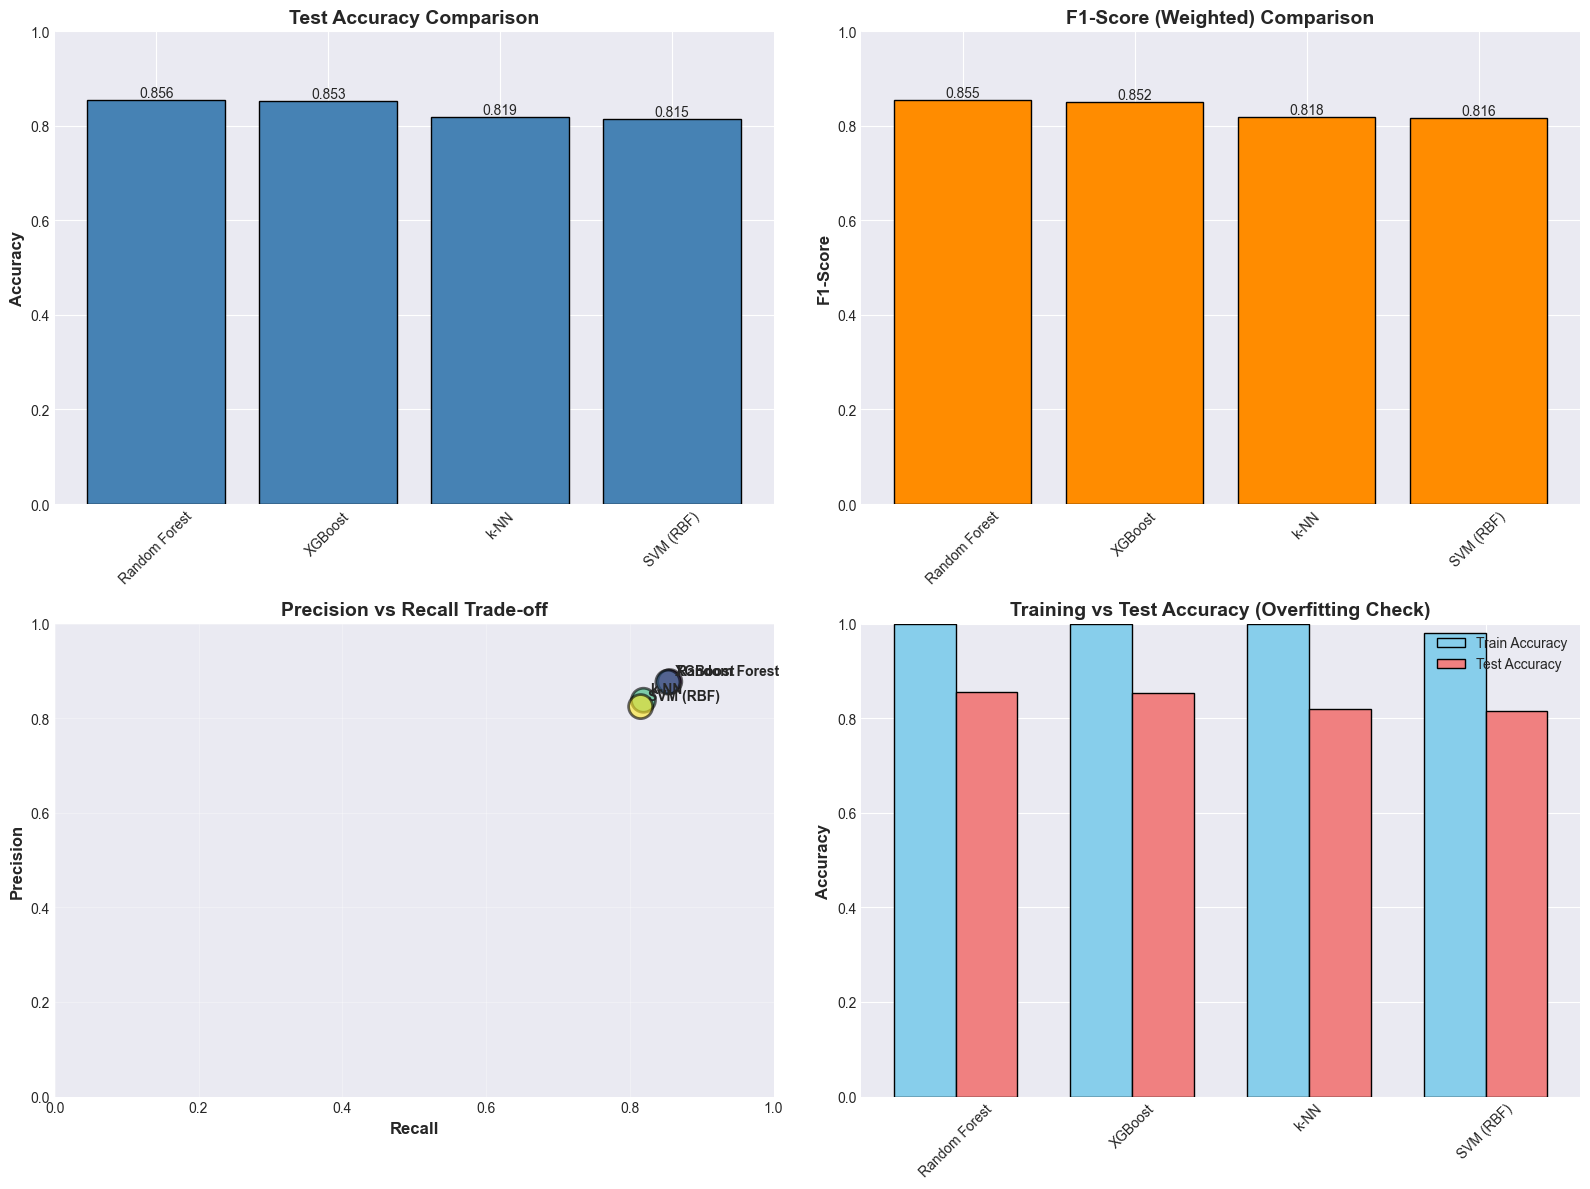


✓ Comparison visualization saved as 'model_comparison.png'


In [44]:
print("\n" + "=" * 80)
print("VISUALIZING MODEL PERFORMANCE")
print("=" * 80)

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Accuracy comparison
ax1 = axes[0, 0]
bars1 = ax1.bar(comparison_df['Model'], comparison_df['Accuracy'], color='steelblue', edgecolor='black')
ax1.set_ylabel('Accuracy', fontsize=12, fontweight='bold')
ax1.set_title('Test Accuracy Comparison', fontsize=14, fontweight='bold')
ax1.set_ylim([0, 1])
ax1.tick_params(axis='x', rotation=45)
# Add value labels on bars
for bar in bars1:
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.3f}', ha='center', va='bottom', fontsize=10)

# 2. F1-Score comparison
ax2 = axes[0, 1]
bars2 = ax2.bar(comparison_df['Model'], comparison_df['F1-Score'], color='darkorange', edgecolor='black')
ax2.set_ylabel('F1-Score', fontsize=12, fontweight='bold')
ax2.set_title('F1-Score (Weighted) Comparison', fontsize=14, fontweight='bold')
ax2.set_ylim([0, 1])
ax2.tick_params(axis='x', rotation=45)
for bar in bars2:
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.3f}', ha='center', va='bottom', fontsize=10)

# 3. Precision vs Recall
ax3 = axes[1, 0]
ax3.scatter(comparison_df['Recall'], comparison_df['Precision'], s=300, alpha=0.6, 
            c=range(len(comparison_df)), cmap='viridis', edgecolors='black', linewidth=2)
for idx, row in comparison_df.iterrows():
    ax3.annotate(row['Model'], (row['Recall'], row['Precision']), 
                xytext=(5, 5), textcoords='offset points', fontsize=10, fontweight='bold')
ax3.set_xlabel('Recall', fontsize=12, fontweight='bold')
ax3.set_ylabel('Precision', fontsize=12, fontweight='bold')
ax3.set_title('Precision vs Recall Trade-off', fontsize=14, fontweight='bold')
ax3.grid(True, alpha=0.3)
ax3.set_xlim([0, 1])
ax3.set_ylim([0, 1])

# 4. Training vs Test Accuracy (overfitting check)
ax4 = axes[1, 1]
x_pos = np.arange(len(comparison_df))
width = 0.35
bars_train = ax4.bar(x_pos - width/2, comparison_df['Train Acc'], width, 
                     label='Train Accuracy', color='skyblue', edgecolor='black')
bars_test = ax4.bar(x_pos + width/2, comparison_df['Accuracy'], width,
                    label='Test Accuracy', color='lightcoral', edgecolor='black')
ax4.set_ylabel('Accuracy', fontsize=12, fontweight='bold')
ax4.set_title('Training vs Test Accuracy (Overfitting Check)', fontsize=14, fontweight='bold')
ax4.set_xticks(x_pos)
ax4.set_xticklabels(comparison_df['Model'], rotation=45)
ax4.legend(fontsize=10)
ax4.set_ylim([0, 1])

plt.tight_layout()
plt.savefig('model_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Comparison visualization saved as 'model_comparison.png'")



CONFUSION MATRICES FOR BEST 2 MODELS


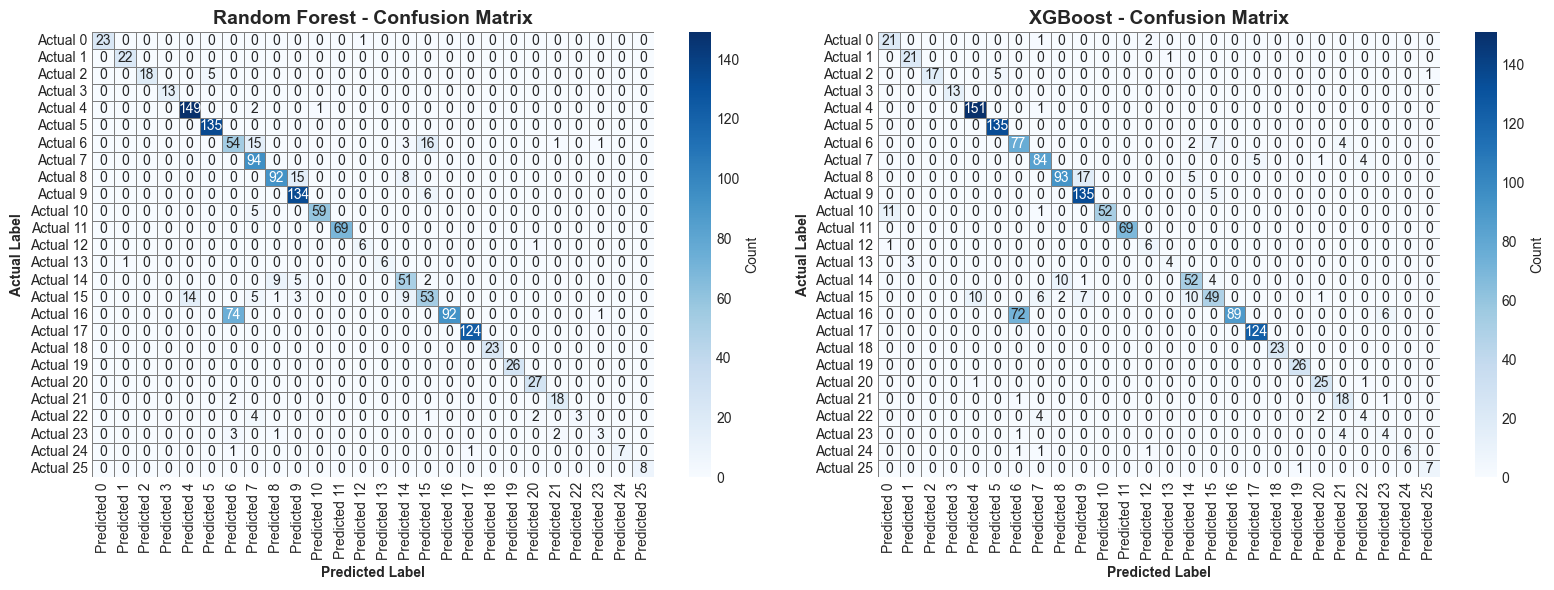


✓ Confusion matrices saved as 'confusion_matrices_best_models.png'


In [45]:
print("\n" + "=" * 80)
print("CONFUSION MATRICES FOR BEST 2 MODELS")
print("=" * 80)

# Get best two models
top_2_models = comparison_df.head(2)['Model'].tolist()

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

for idx, model_name in enumerate(top_2_models):
    result = results[model_name]
    cm = result['confusion_matrix']
    
    # Create confusion matrix heatmap
    df_cm = pd.DataFrame(cm, 
                        index=[f'Actual {i}' for i in range(cm.shape[0])],
                        columns=[f'Predicted {i}' for i in range(cm.shape[1])])
    
    ax = axes[idx]
    sns.heatmap(df_cm, annot=True, fmt='d', cmap='Blues', ax=ax,
                cbar_kws={'label': 'Count'}, linewidths=0.5, linecolor='gray')
    ax.set_title(f'{model_name} - Confusion Matrix', fontsize=14, fontweight='bold')
    ax.set_ylabel('Actual Label', fontweight='bold')
    ax.set_xlabel('Predicted Label', fontweight='bold')

plt.tight_layout()
plt.savefig('confusion_matrices_best_models.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Confusion matrices saved as 'confusion_matrices_best_models.png'")


In [46]:
print("\n" + "=" * 80)
print("BASELINE MODELS SUMMARY")
print("=" * 80)

print(f"\n✅ COMPLETED:")
print(f"  1. Trained 4 baseline models with hyperparameter tuning")
print(f"  2. Evaluated using multiple metrics (Accuracy, Precision, Recall, F1)")
print(f"  3. Compared inference time for real-time suitability")
print(f"  4. Analyzed confusion matrices and feature importance")

print(f"\n🏆 BEST BASELINE MODEL: {best_model_name}")
print(f"   F1-Score: {results[best_model_name]['f1']:.4f}")
print(f"   Accuracy: {results[best_model_name]['accuracy']:.4f}")
print(f"   Suitable for real-time? {results[best_model_name].get('inference_time', 'N/A')}")

print(f"\n📊 ALL MODELS RANKED BY F1-SCORE:")
for idx, row in comparison_df.iterrows():
    print(f"   {idx+1}. {row['Model']}: {row['F1-Score']:.4f}")

print(f"\n🎯 NEXT SECTION: Deep Learning Models")
print(f"   We'll train CNN, LSTM, and other neural networks")
print(f"   Expected to provide better accuracy but slower inference")



BASELINE MODELS SUMMARY

✅ COMPLETED:
  1. Trained 4 baseline models with hyperparameter tuning
  2. Evaluated using multiple metrics (Accuracy, Precision, Recall, F1)
  3. Compared inference time for real-time suitability
  4. Analyzed confusion matrices and feature importance

🏆 BEST BASELINE MODEL: Random Forest
   F1-Score: 0.8548
   Accuracy: 0.8556
   Suitable for real-time? N/A

📊 ALL MODELS RANKED BY F1-SCORE:
   1. Random Forest: 0.8548
   4. XGBoost: 0.8515
   3. k-NN: 0.8178
   2. SVM (RBF): 0.8158

🎯 NEXT SECTION: Deep Learning Models
   We'll train CNN, LSTM, and other neural networks
   Expected to provide better accuracy but slower inference
